# Phytoplankton community composition

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import utils
import plot

import data_collections

import glodap 

xr.set_options(arithmetic_join='exact');

In [18]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.62:40382 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/43138/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Read the model data

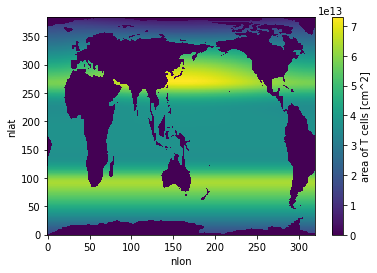

In [19]:
grid = pop_tools.get_grid('POP_gx1v7')
masked_area = grid.TAREA.where(grid.REGION_MASK > 0).fillna(0.)
masked_area.plot()

In [20]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400 * 365.
nmolcm2_to_mmolm2 = 1e-9 * 1e4 * 1e3

varlist = [
    'photoC_TOT_zint_100m',
    'photoC_sp_zint_100m',    
    'photoC_diat_zint_100m',
    'photoC_diaz_zint_100m',
    'zoo_prod_zint_100m',
    'spC_zint_100m',
    'diatC_zint_100m',    
    'diazC_zint_100m',
    'zooC_zint_100m',
]

coll = data_collections.epoch_mean(
    query=dict(experiment='historical', stream='pop.h'),
)
dsets = coll.to_dataset_dict(varlist, clobber=False)
_, ds = dsets.popitem()

with xr.set_options(keep_attrs=True):
    ds = ds.mean('member_id')

# mask out marginal seas    
ds = ds.where(masked_area)

# retain interesting variables
ds = ds[varlist]

for v in varlist:
    assert ds[v].attrs['units'] in ['mmol/m^3 cm/s', 'mmol/m^3 cm']
    assert ds[v].dims == ('nlat', 'nlon')
    
    if ds[v].attrs['units'] == 'mmol/m^3 cm/s':
        ds[v] = ds[v] * nmolcm2s_to_molm2yr
        ds[v].attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
    elif ds[v].attrs['units'] == 'mmol/m^3 cm':
        ds[v] = ds[v] * nmolcm2_to_mmolm2
        ds[v].attrs['units'] = 'mmol m$^{-2}$'
        
ds

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 320)
Coordinates:
    ULONG                  (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    ULAT                   (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_TOT_zint_100m   (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_sp_zint_100m    (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_diat_zint_100m  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_diaz_zint_100m  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    zoo_prod_zint_100m     (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    spC_zint_100m          (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    diatC_zint_100m        (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    diazC_zint_100m        (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    zooC_zint_100m         (nlat, nlon) float64 nan nan nan nan ... nan nan nan

In [21]:
client.close()
cluster.close()
del client
del cluster

## Make plots

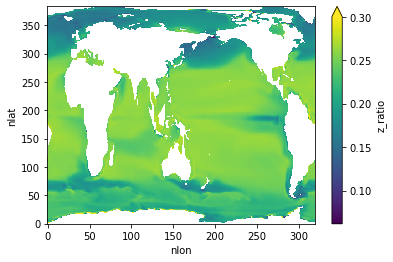

In [22]:
ds['z_ratio'] = ds.zoo_prod_zint_100m / ds.photoC_TOT_zint_100m
ds.z_ratio.plot(vmax=0.3)

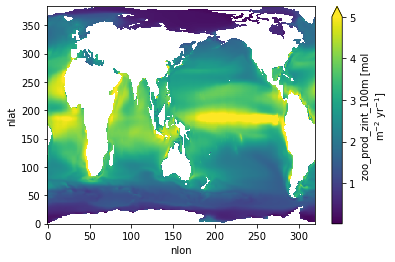

In [23]:
ds.zoo_prod_zint_100m.plot(vmax=5.)

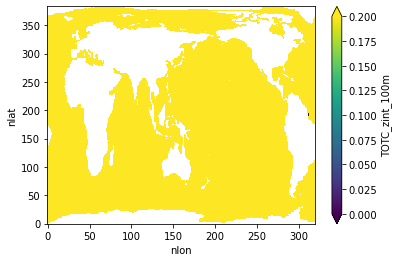

In [24]:
ds['TOTC_zint_100m'] = (
    ds.diatC_zint_100m + 
    ds.spC_zint_100m + 
    ds.diazC_zint_100m
)
ds.TOTC_zint_100m.plot(vmin=0, vmax=0.2)

In [25]:
ds_plot = utils.pop_add_cyclic(ds)
ds_plot

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                  (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    photoC_TOT_zint_100m   (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_sp_zint_100m    (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_diat_zint_100m  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    photoC_diaz_zint_100m  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    ...                     ...
    spC_zint_100m          (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    diatC_zint_100m        (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    diazC_zint_100m        (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    zooC_zint_100m         (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    z_ratio                (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    TOTC_zint_100m         (nlat, nlon) float64 nan nan nan nan ... nan nan nan

In [26]:
levels = dict()
for v in ds.data_vars:
    # main plot
    levels[v] = plot.nice_levels(ds[v], percentile=[0, 97.5])
        
print(levels)    

{'photoC_TOT_zint_100m': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]), 'photoC_sp_zint_100m': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. ]), 'photoC_diat_zint_100m': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5]), 'photoC_diaz_zint_100m': array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96]), 'zoo_prod_zint_100m': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
       2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]), 'spC_zint_100m': array([-0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 

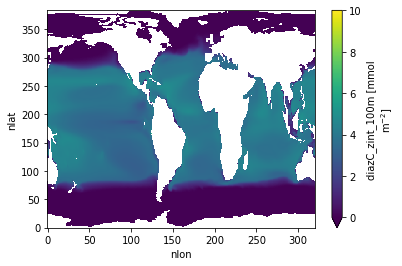

In [27]:
ds_plot.diazC_zint_100m.plot(vmin=0., vmax=10)

In [28]:
from matplotlib import ticker, cm

cmap_field = cmocean.cm.dense
  
contour_spec = {}
long_name = {}
levels['photoC_TOT_zint_100m'] = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50., 100.]
for field in ['photoC_diat_zint_100m', 'photoC_sp_zint_100m', 'photoC_diaz_zint_100m']:
    contour_spec[field] = dict(
        levels=levels['photoC_TOT_zint_100m'],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels['photoC_TOT_zint_100m'], ncolors=cmap_field.N),                
        #norm=colors.LogNorm(vmin=0.01, vmax=100.),
        #locator=ticker.LogLocator(),
    )

    
levels['TOTC_zint_100m'] = [0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.8, 1., 2., 4., 8., 10., 20., 40., 80., 100.]
for field in ['diatC_zint_100m', 'spC_zint_100m', 'diazC_zint_100m']:
    contour_spec[field] = dict(
        levels=levels['TOTC_zint_100m'],
        extend='max',
        cmap=cmap_field,
        #norm=colors.LogNorm(vmin=0.01, vmax=100.),
        #locator=ticker.LogLocator(),
        norm=colors.BoundaryNorm(levels['TOTC_zint_100m'], ncolors=cmap_field.N),        
    )
    
titles = dict(
    photoC_sp_zint_100m='NPP (small phyto)',
    photoC_diat_zint_100m='NPP (diatoms)',
    photoC_diaz_zint_100m='NPP (diazotrophs)',
    spC_zint_100m='C${org}$ (small phyto)',
    diatC_zint_100m ='C${org}$ (diatoms)',
    diazC_zint_100m='C${org}$ (diazotrophs)',
)
  
taxa = dict(
    diat='Diatoms',
    sp='Small phyto',
    diaz='Diazotrophs',
)

In [29]:
np.arange(-2, 3)



array([-2, -1,  0,  1,  2])

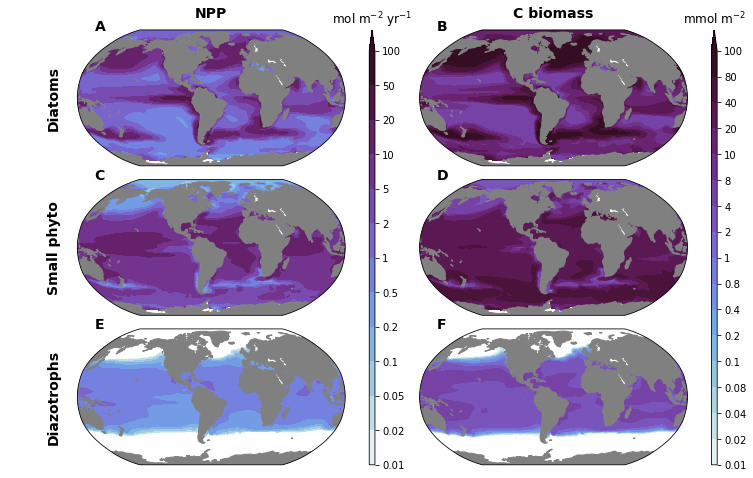

In [30]:

fig = plt.figure(figsize=(12, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.02)*ncol,
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j*3], projection=prj)

for j in range(ncol): 
    caxs[j] = plt.subplot(gs[:, j*3+1])

cmap_field = cmocean.cm.dense

rows = ['diat', 'sp', 'diaz']
cols = ['photoC_{0}_zint_100m', '{0}C_zint_100m']

for n in range(nrow * ncol):
    
    i, j = np.unravel_index(n, axs.shape)
    
    field = cols[j].format(rows[i])
    
    ax = axs[i, j]
    ax.set_global()
    cf = ax.contourf(
        ds_plot.TLONG, ds_plot.TLAT, ds_plot[field],
        **contour_spec[field],
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )                               
    #ax.set_title(titles[field]) #dsp[field].attrs['title_str'])
    
    
    if i == n - 1:
        levs = contour_spec[field]['levels']
        
        cb = plt.colorbar(cf, cax=caxs[j], ticks=levs)
        cb.ax.set_yticklabels([plot.tick_format(f) for f in levs])
        
        if 'units' in ds_plot[field].attrs:
            cb.ax.set_title(ds_plot[field].attrs['units'])
    
utils.subplot_col_labels(axs[0, :], ['NPP', 'C biomass'])    
utils.subplot_row_labels(axs[:, 0], [taxa[f] for f in rows], xoff=70)

utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('community-composition')